In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Features to Use
# -----------------------------
features = [
    "LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered",
    "LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered",
    "LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered",
    "Left_Ankle_Angle", "Left_Force",
    "RT_GyroX_filtered", "RT_GyroY_filtered", "RT_GyroZ_filtered",
    "RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered",
    "RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered",
    "Right_Ankle_Angle", "Right_Force"
]

# -----------------------------
# Helper Function for RFECV
# -----------------------------
def run_rfecv(X, y, side_label):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5)

    rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')
    rfecv.fit(X, y_encoded)

    # Results
    selected_features = X.columns[rfecv.support_]
    print(f"\n🔍 {side_label} Gait Phase Classification")
    print(f"Optimal number of features: {rfecv.n_features_}")
    print("Selected features:")
    for feat in selected_features:
        print(f" - {feat}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(
        range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
        rfecv.cv_results_['mean_test_score'],
        marker='o'
    )
    plt.title(f"RFECV - {side_label} Gait Phase")
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return selected_features.tolist()


In [2]:
import os
import pandas as pd

# Folder containing your CSV files
folder_path = "labelled"  # 🔁 Replace this with your actual folder name

# Initialize list to hold DataFrames
all_dfs = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['TestID'] = filename  # Optional: tag with filename or test ID
        all_dfs.append(df)

# Combine all into a single DataFrame
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"✅ Loaded {len(all_dfs)} files, total rows: {len(full_df)}")

✅ Loaded 10 files, total rows: 61703



🔍 Left Gait Phase Classification
Optimal number of features: 9
Selected features:
 - Left_Force
 - RT_GyroY_filtered
 - RT_GyroZ_filtered
 - RS_GyroZ_filtered
 - RA_GyroX_filtered
 - RA_GyroY_filtered
 - RA_GyroZ_filtered
 - Right_Ankle_Angle
 - Right_Force


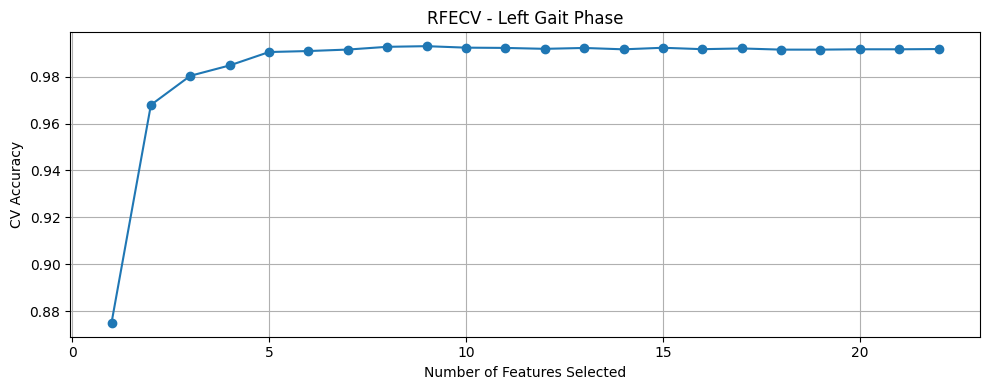


🔍 Right Gait Phase Classification
Optimal number of features: 11
Selected features:
 - LT_GyroX_filtered
 - LT_GyroZ_filtered
 - LS_GyroZ_filtered
 - LA_GyroX_filtered
 - LA_GyroZ_filtered
 - Left_Ankle_Angle
 - Left_Force
 - RT_GyroZ_filtered
 - RA_GyroX_filtered
 - Right_Ankle_Angle
 - Right_Force


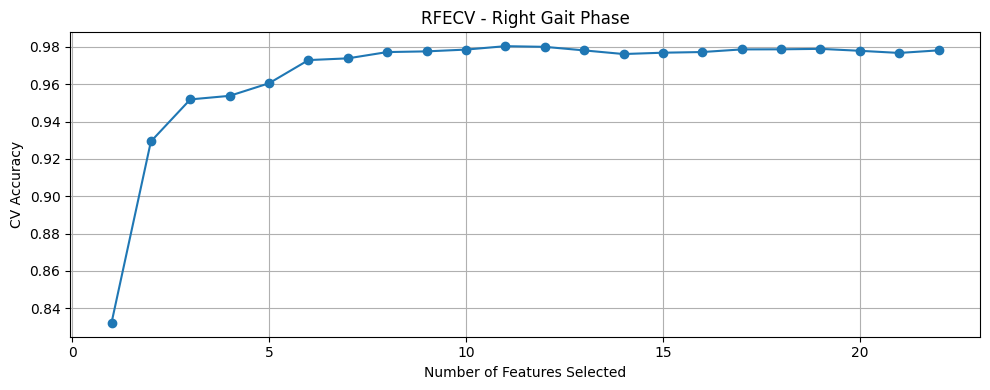

In [3]:
# -----------------------------
# Run for Both Sides
# -----------------------------
X = full_df[features]

left_features = run_rfecv(X, full_df["Left_Gait_Phase"], "Left")
right_features = run_rfecv(X, full_df["Right_Gait_Phase"], "Right")

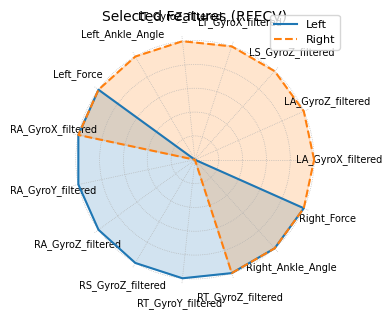

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

# Selected features (replace with actual lists from RFECV)
# left_features = [
#     "Left_Force", "RS_GyroZ_filtered", "RA_GyroY_filtered",
#     "RA_GyroZ_filtered", "Right_Force"
# ]
# right_features = [
#     "Right_Force", "RA_GyroZ_filtered", "RT_GyroY_filtered",
#     "RS_GyroX_filtered", "Right_Ankle_Angle"
# ]

# Prepare data
all_features = sorted(list(set(left_features + right_features)))
data = pd.DataFrame(index=all_features)
data['Left'] = [1 if f in left_features else 0 for f in all_features]
data['Right'] = [1 if f in right_features else 0 for f in all_features]

categories = list(data.index)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Radar plot
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

# Left Gait
left_vals = data['Left'].tolist() + [data['Left'].tolist()[0]]
ax.plot(angles, left_vals, label='Left', color='tab:blue')
ax.fill(angles, left_vals, color='tab:blue', alpha=0.2)

# Right Gait
right_vals = data['Right'].tolist() + [data['Right'].tolist()[0]]
ax.plot(angles, right_vals, label='Right', color='tab:orange', linestyle='--')
ax.fill(angles, right_vals, color='tab:orange', alpha=0.2)

# Style adjustments for compactness
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=7)
ax.set_yticklabels([])
ax.grid(True, linestyle='dotted', linewidth=0.5)
ax.spines['polar'].set_visible(False)

# Title and legend
plt.title("Selected Features (RFECV)", fontsize=10, pad=10)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=8)

plt.tight_layout()
plt.show()
